In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [18]:
normalize = True
data_size = 10**6
n_moments = 2

In [3]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=data_size),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=data_size)}

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [19]:
x = dict()
p = dict()
if normalize:
    x['gen'] = zscore(datasets['Pythia26']['gen_widths']) #gen = particle leve
    x['sim'] = zscore(datasets['Pythia26']['sim_widths']) #sim = detector level
    x['truth'] = zscore(datasets['Herwig']['gen_widths'])
    x['data'] = zscore(datasets['Herwig']['sim_widths'])

    p['gen'] = zscore(datasets['Pythia26']['gen_jets'][:,0]) #gen = particle level
    p['sim'] = zscore(datasets['Pythia26']['sim_jets'][:,0]) #sim = detector level
    p['truth'] = zscore(datasets['Herwig']['gen_jets'][:,0])
    p['data'] = zscore(datasets['Herwig']['sim_jets'][:,0])

else:
    x['gen'] =datasets['Pythia26']['gen_widths'] #gen = particle leve
    x['sim'] = datasets['Pythia26']['sim_widths'] #sim = detector level
    x['truth'] = datasets['Herwig']['gen_widths']
    x['data'] = datasets['Herwig']['sim_widths']

    p['gen'] = datasets['Pythia26']['gen_jets'][:,0] #gen = particle level
    p['sim'] = datasets['Pythia26']['sim_jets'][:,0] #sim = detector level
    p['truth'] = datasets['Herwig']['gen_jets'][:,0]
    p['data'] = datasets['Herwig']['sim_jets'][:,0]

In [20]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._l = self.add_weight(name='l', 
                                    shape=(n_moments,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.exp(sum([self._l[i]* x**(i+1) for i in range(n_moments)]))

In [21]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    #tf.print("weights",weights_0,weights_1)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [22]:
myc = 0.1
mymodel_inputtest = Input(shape=(1,))
    
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((1, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')

model_discrimantor.trainable = False
mymodel_gan = Input(shape=(1,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))


gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')

In [23]:
xvals = np.stack([np.concatenate([x['gen'],x['truth']]),
                  np.concatenate([x['sim'],x['data']])], axis = 1)
yvals = np.concatenate([np.ones(len(x['sim'])),np.zeros(len(x['data']))])

X_train, X_test, Y_train, Y_test = train_test_split(xvals, yvals)

In [24]:
n_epochs = 10
n_batch = 128*10
n_batches = X_train.shape[0] // n_batch

for i in range(n_epochs):
    for j in range(n_batches):
        X_batch = X_train[j*n_batch: (j+1)*n_batch]
        Y_batch = Y_train[j*n_batch:(j+1)*n_batch]
        W_batch = np.array(model_generator(X_batch[:, 0])).flatten()
        W_batch[Y_batch==1] = 1

        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)

        model_discrimantor.train_on_batch(X_batch[:, 1], Y_batch_2)

        gan_model.train_on_batch(X_batch[:, 0][Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

    mylambda = np.array(model_generator.layers[-1].get_weights())
    print("on epoch=",i, mylambda)

on epoch= 0 [[-0.04699842  0.02400699]]
on epoch= 1 [[-0.05884791  0.02813422]]
on epoch= 2 [[-0.05430708  0.03199748]]
on epoch= 3 [[-0.05391467  0.03290164]]
on epoch= 4 [[-0.05494386  0.03288316]]
on epoch= 5 [[-0.05436832  0.03266941]]
on epoch= 6 [[-0.05604746  0.03123366]]
on epoch= 7 [[-0.05864517  0.02957032]]
on epoch= 8 [[-0.05693305  0.03209328]]
on epoch= 9 [[-0.05961331  0.02998061]]


In [25]:
arr = np.exp(np.sum([mylambda[:, k]*x['gen']**(k+1) for k in range(n_moments)],axis = 0))
weights = np.concatenate([arr*len(x['gen'])/np.sum(arr), np.ones(len(x['gen']))])

X_train, X_test, Y_train, Y_test, w_train, w_test = train_test_split(xvals, yvals, weights)

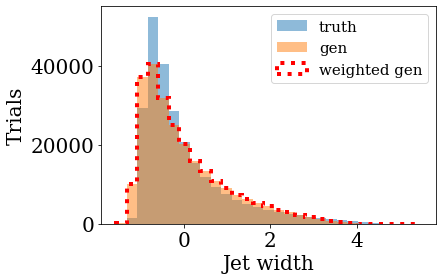

In [26]:
nbins = 30
bins = np.linspace(X_test.min(),X_test.max(),nbins)

_,_,_=plt.hist(X_test[Y_test==1][:, 0], bins=bins, alpha=0.5,label="truth")
_,_,_=plt.hist(X_test[Y_test==0][:, 0], bins=bins, alpha=0.5,label="gen")
_,_,_=plt.hist(X_test[Y_test==0][:, 0], bins=bins, weights=w_test[Y_test==0],histtype="step",color="r",ls=":", lw=4,label="weighted gen")
plt.legend(fontsize=15)
plt.xlabel("Jet width")
plt.ylabel("Trials")
plt.savefig("jetexample.pdf", bbox_inches='tight', transparent=True)

(array([1.20889e+05, 1.86078e+05, 8.71650e+04, 4.73250e+04, 2.80480e+04,
        1.68400e+04, 9.26200e+03, 3.63200e+03, 6.90000e+02, 7.10000e+01]),
 array([-1.41060373, -0.73348156, -0.0563594 ,  0.62076277,  1.29788493,
         1.97500709,  2.65212926,  3.32925142,  4.00637359,  4.68349575,
         5.36061792]),
 <BarContainer object of 10 artists>)

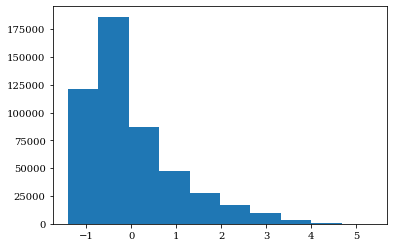

In [14]:
plt.hist(X_test[:, 0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

In [ ]:
a, b, c = plt.hist(p_gen/1000, bins = np.linspace(.2, .5, 50))
d, e, f = plt.hist(p_truth/1000, bins = np.linspace(.2, .5, 50))

In [ ]:
plt.plot(d/(a+10e-5))
plt.ylim(0.8,1.2)
np.polyfit([(b[i] + b[i+1])/2 for i in range(len(b)-1)], d/(a+10e-5), 1)

In [ ]:
c, m = np.polyfit([(b[i] + b[i+1])/2 for i in range(len(b)-1)], d/(a+10e-5), 1)

In [ ]:
print(c)